## Set-Up

### Import Libraries

In [1]:
# pip install libraries, should the module not be found

In [2]:
# Import general libraries 
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Import geospatial libraries
import xarray as xr
import rioxarray as rioxr
from shapely.geometry import Polygon

# Import planetary computer tools
import pystac_client 
import planetary_computer

# for images and mapping
from IPython.display import Image
import contextily as ctx

### Import Data

In [3]:
# Phoenix data
# Create path to data folder
arizona_fp = os.path.join("data","tl_2024_04_cousub.shp")

# Assign 2024 Phoenix subdivison shapefile US Census Bureau to variable
arizona_sub = gpd.read_file(arizona_fp)

In [4]:
# Access MPC catalog
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [5]:
# Create coordinates for bounding box
bbox = {
    "type": "Polygon",
    "coordinates":[
        [
            [-112.826843, 32.974108],
            [-112.826843, 33.863574],
            [-111.184387, 33.863574],
            [-111.184387, 32.974108],
            [-112.826843, 32.974108]
        ]
    ],
}

# Specify tume range
time_range = "2017/2020"

In [6]:
# Search catalog
search = catalog.search(
    collections = ['io-biodiversity'],
    intersects = bbox,
    datetime = time_range)
search

In [7]:
# Retrieve items
items = search.item_collection()

# View number of items in search
len(items)

# Manually explore items to find 2017 and 2020
items # The data is in the 1st and 4th items

# Select and name 2017 and 2020 items
bio_2017 = items[0]
bio_2020 = items[3]

## Data Analysis and Visualization

### Data Exploration

In [8]:
# Explore arizona_sub head
pd.set_option("display.max.columns", None)
arizona_sub.head(3)

,STATEFP,COUNTYFP,COUSUBFP,COUSUBNS,GEOID,GEOIDFQ,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,04,005,91198,01934931,0400591198,0600000US0400591198,Flagstaff,Flagstaff CCD,22,Z5,G4040,S,12231962349,44576380,+35.1066122,-111.3662507,"POLYGON ((-112.13370 35.85596, -112.13368 35.8..."
1,04,005,91838,01934953,0400591838,0600000US0400591838,Kaibab Plateau,Kaibab Plateau CCD,22,Z5,G4040,S,7228864156,29327221,+36.5991097,-112.1368033,"POLYGON ((-112.66039 36.53941, -112.66033 36.5..."
2,04,005,91683,01934950,0400591683,0600000US0400591683,Hualapai,Hualapai CCD,22,Z5,G4040,S,2342313339,3772690,+35.9271665,-113.1170408,"POLYGON ((-113.35416 36.04097, -113.35416 36.0..."


In [9]:
# Explore arizona_sub tail
arizona_sub.tail(3)

,STATEFP,COUNTYFP,COUSUBFP,COUSUBNS,GEOID,GEOIDFQ,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
77,04,003,90969,01934936,0400390969,0600000US0400390969,Douglas,Douglas CCD,22,Z5,G4040,S,641500771,176635,+31.4446761,-109.4183013,"POLYGON ((-109.79275 31.33442, -109.79266 31.3..."
78,04,003,93182,01934980,0400393182,0600000US0400393182,Sierra Vista,Sierra Vista CCD,22,Z5,G4040,S,1814147965,1074824,+31.7198887,-110.1649608,"POLYGON ((-110.46078 31.56927, -110.46078 31.5..."
79,04,003,91122,01934939,0400391122,0600000US0400391122,Elfrida,Elfrida CCD,22,Z5,G4040,S,4176450000,5652149,+31.6613311,-109.3906592,"POLYGON ((-110.03718 31.72418, -110.03617 31.7..."


In [10]:
arizona_sub.dtypes

STATEFP       object
COUNTYFP      object
COUSUBFP      object
COUSUBNS      object
GEOID         object
GEOIDFQ       object
NAME          object
NAMELSAD      object
LSAD          object
CLASSFP       object
MTFCC         object
FUNCSTAT      object
ALAND          int64
AWATER         int64
INTPTLAT      object
INTPTLON      object
geometry    geometry
dtype: object

In [11]:
arizona_sub.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

### Data Processing

In [12]:
# Simplify column names by replacing spaces and no capitilization
arizona_sub.columns = (arizona_sub.columns
                  .str.lower()
                  .str.replace(' ','_')
                )

In [13]:
# Select Phoenix County from Arizona subdivisions
phoenix = arizona_sub[arizona_sub['name'] == 'Phoenix']

### Phoenix Subdivision

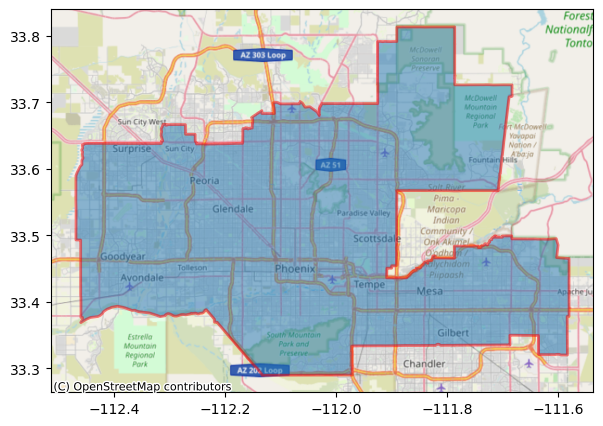

In [14]:
# Create Phoenix Map
fig, ax = plt.subplots(figsize = (7,7))

phoenix.plot(ax = ax,
             alpha = 0.5,
             edgecolor = "red",
             linewidth = 2)

# Add contextual basemap
ctx.add_basemap(ax, source = ctx.providers.OpenStreetMap.DE, crs = phoenix.crs)

## Biodiversity Intactness in Phoenix, Arizona

Calculate the percentage of area of the Phoenix subdivision with a BII of at least 0.75 in 2017 and obtain the same calculation for 2020. 

### Explore Data

In [15]:
# Explore assets within bio_2017 and bio_2020
# bio_2017.assets # Uncomment to explore
# bio_2020.assets # Uncomment to explore

In [16]:
# Find assets within the 2017 items
for key in bio_2017.assets.keys():
    print(key, '--', bio_2017.assets[key].title)

data -- Biodiversity Intactness
tilejson -- TileJSON with default rendering
rendered_preview -- Rendered preview


In [17]:
# Find assets within the 2020 items
for key in bio_2020.assets.keys():
    print(key, '--', bio_2020.assets[key].title)

data -- Biodiversity Intactness
tilejson -- TileJSON with default rendering
rendered_preview -- Rendered preview


In [18]:
# Plot rendered preview
# bio_2017_data
Image(url=bio_2017.assets['rendered_preview'].href, width=500) # Uncomment to view

In [19]:
# Image(url=bio_2020.assets['rendered_preview'].href, width=500) # Uncomment to view

In [20]:
# Retrieve 2017 biodiversity intactness data and href
bio_2017_data = bio_2017.assets['data']
bio_2017_data = rioxr.open_rasterio(bio_2017_data.href)

# Retrieve 2020 biodiversity intactness data and href
bio_2020_data = bio_2020.assets['data']
bio_2020_data = rioxr.open_rasterio(bio_2020_data.href)

### Clean Data

In [21]:
# Match CRS of selected data and Phoenix
bio_2017_data.rio.crs

CRS.from_epsg(4326)

In [22]:
# Check both data CRS match
assert(bio_2017_data.rio.crs == bio_2020_data.rio.crs)

In [23]:
# Reproject phoenix crs to EPSG 4326 
phoenix = phoenix.to_crs(bio_2017_data.rio.crs)

# Check all CRS match
assert((phoenix.crs == bio_2020_data.rio.crs) & (phoenix.crs == bio_2017_data.rio.crs))

In [ ]:
# Clip 2017 raster to Phoenix
bio_2017_clip = bio_2017_data.rio.clip(phoenix['geometry'])

In [ ]:
# Clip 2020 raster to Phoenix
bio_2020_clip =  bio_2020_data.rio.clip(phoenix['geometry'])